In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Importing the Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
from os import listdir
from os.path import isfile, join
import string
import re
import pickle
import gc
import torch
from torch import nn
from tqdm import tqdm

torch.manual_seed(1)
np.random.seed(1)

### 2. Extracting the Abstracts from the JSON files

In [ ]:
def extract_abstract(filename):
    file = open(filename)
    paper_content = json.load(file) 
    abstract = ""

    if 'abstract' in paper_content:          # First we go through all the keys and check for 'abstract'
        for bt in paper_content['abstract']:
            abstract = abstract + bt['text']          # Next we need "text" part from the abstract. We add them to the corpus

    return abstract.lower()

In [ ]:
files = [f for f in listdir('./pdf_json/') if isfile(join('./pdf_json/', f))]      # list of all the files in the directory

In [ ]:
corpus_list = []

for f in tqdm(files):
    try:
      corpus1 = extract_abstract('./pdf_json/' + f)
      
      # remove numbers
      corpus1 = ''.join([_ for _ in corpus1 if not _.isdigit()])

      # remove emails
      corpus1 = re.sub(r"\S*@\S*\s?",'', corpus1)

      # remove punctuation except fullstop
      remove = string.punctuation
      remove = re.sub(r"[.:-]+", "", remove)
      pattern = r"[{}]".format(remove + '-')
      corpus1 = re.sub(pattern, "", corpus1)

      # remove url
      corpus1 = re.sub(r'http\S+', '', corpus1)
      
      corpus_list.append(corpus1)
    except:
      continue

100%|██████████| 56529/56529 [00:48<00:00, 1173.12it/s]


### 3. Saving the Corpus in the Disk

In [ ]:
corpus = '\n'.join(corpus_list)
with open('corpus.txt', 'w', encoding='utf8') as text_file:
    for _ in tqdm(corpus):
        text_file.write(_)

100%|██████████| 57412057/57412057 [00:14<00:00, 3860844.13it/s]


- Removing the New Lines

In [ ]:
# Open the input file for reading
with open('corpus.txt', 'r') as input_file:

    # Open the output file for writing
    with open('output.txt', 'w') as output_file:

        # Loop through each line in the input file
        for line in input_file:

            # Remove the new line from the line
            line = line.rstrip()

            # Write the modified line to the output file
            output_file.write(line)

### 4. Preparing the Datasets

In [ ]:
# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Reading the abstract corpus
with open('/content/drive/MyDrive/NLP/output.txt', 'r') as f:
    text = f.read()

words = text.split()

In [ ]:
# creating a dictionary to keep track of the indices for all tokens in the vocab
word_to_ix = {}
for word in words:
    if word not in word_to_ix:
        word_to_ix[word] = len(word_to_ix)

In [ ]:
vocab_size = len(word_to_ix)
seq_length = 10
print("Our vocabulary size is:", vocab_size)

Our vocabulary size is: 80492


In [ ]:
inputs = []
labels = []

# Preparing the input & output labels. Using the previous n-length sequence we want to predict (n+1)th word
for i in range(len(words) - seq_length):
    inputs.append([word_to_ix[word] for word in words[i: i+seq_length]])
    labels.append(word_to_ix[words[i+seq_length]])

In [ ]:
# Loading the input and output tensors to device (GPU)
inputs = torch.tensor(inputs).to(device)
labels = torch.tensor(labels).to(device)

### 5. Creating the Model

In [ ]:
class BiLSTM(nn.Module):
    '''
    We will use bidirectional LSTM for our purpose with two layers
    '''
    def __init__(self, vocab_size, hidden_size):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=2, bidirectional=True)
        self.linear = nn.Linear(2*hidden_size, vocab_size)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.lstm(embedded.permute(1, 0, 2))
        hidden_cat = torch.cat((hidden[-2][0], hidden[-1][0]), dim=1).to(device)
        out = self.linear(hidden_cat)
        return out

### 6. Creating the Training Loop

In [ ]:
def train(model, inputs, labels, num_epochs, batch_size, learning_rate):
    loss_fn = nn.CrossEntropyLoss()                # We use the cross entropy loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, mode='triangular2', cycle_momentum=False)         # We also use scheduler to update the learning rate cyclically
    num_batches = len(inputs) // batch_size

    epochs_list = []
    train_loss_list = []
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        for i in tqdm(range(num_batches)):
            batch_inputs = inputs[i*batch_size: (i+1)*batch_size]
            batch_labels = labels[i*batch_size: (i+1)*batch_size]
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = loss_fn(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()

        epochs_list.append(epoch)
        train_loss_list.append(total_loss/num_batches)
            
        print(f"Epoch: {epoch+1}/{num_epochs} | Loss: {total_loss/num_batches:.4f}")
    
    return epochs_list, train_loss_list

In [ ]:
hidden_size = 128
batch_size = 64
learning_rate = 0.005
num_epochs = 100

### 7. Training the Model

In [ ]:
model = BiLSTM(vocab_size, hidden_size).to(device)

In [ ]:
epochs_list, train_loss_list = train(model, inputs, labels, num_epochs, batch_size, learning_rate)

100%|██████████| 23287/23287 [04:10<00:00, 93.97it/s]


Epoch: 1/100 | Loss: 5.4165


100%|██████████| 23287/23287 [04:09<00:00, 93.04it/s]


Epoch: 2/100 | Loss: 4.7049


100%|██████████| 23287/23287 [04:09<00:00, 93.58it/s]


Epoch: 3/100 | Loss: 4.3523


100%|██████████| 23287/23287 [04:09<00:00, 93.65it/s]


Epoch: 4/100 | Loss: 3.8078


100%|██████████| 23287/23287 [04:10<00:00, 93.20it/s]


Epoch: 5/100 | Loss: 3.3638


100%|██████████| 23287/23287 [04:09<00:00, 93.91it/s]


Epoch: 6/100 | Loss: 2.8237


100%|██████████| 23287/23287 [04:09<00:00, 93.57it/s]


Epoch: 7/100 | Loss: 2.7625


100%|██████████| 23287/23287 [04:09<00:00, 93.03it/s]


Epoch: 8/100 | Loss: 2.5958


100%|██████████| 23287/23287 [04:10<00:00, 93.31it/s]


Epoch: 9/100 | Loss: 1.9038


100%|██████████| 23287/23287 [04:09<00:00, 93.74it/s]


Epoch: 10/100 | Loss: 1.8202


100%|██████████| 23287/23287 [04:09<00:00, 93.76it/s]


Epoch: 11/100 | Loss: 1.7489


100%|██████████| 23287/23287 [04:10<00:00, 93.25it/s]


Epoch: 12/100 | Loss: 1.6443


100%|██████████| 23287/23287 [04:09<00:00, 93.11it/s]


Epoch: 13/100 | Loss: 1.5740


100%|██████████| 23287/23287 [04:09<00:00, 93.24it/s]


Epoch: 14/100 | Loss: 1.4428


100%|██████████| 23287/23287 [04:09<00:00, 93.47it/s]


Epoch: 15/100 | Loss: 1.3750


100%|██████████| 23287/23287 [04:09<00:00, 93.36it/s]


Epoch: 16/100 | Loss: 1.2340


100%|██████████| 23287/23287 [04:09<00:00, 93.39it/s]


Epoch: 17/100 | Loss: 1.2131


100%|██████████| 23287/23287 [04:11<00:00, 93.22it/s]


Epoch: 18/100 | Loss: 1.1812


100%|██████████| 23287/23287 [04:09<00:00, 93.52it/s]


Epoch: 19/100 | Loss: 1.1603


100%|██████████| 23287/23287 [04:09<00:00, 93.25it/s]


Epoch: 20/100 | Loss: 1.1340


100%|██████████| 23287/23287 [04:09<00:00, 93.91it/s]


Epoch: 21/100 | Loss: 1.1142


100%|██████████| 23287/23287 [04:09<00:00, 93.31it/s]


Epoch: 22/100 | Loss: 1.1056


100%|██████████| 23287/23287 [04:09<00:00, 93.99it/s]


Epoch: 23/100 | Loss: 1.0889


100%|██████████| 23287/23287 [04:09<00:00, 93.21it/s]


Epoch: 24/100 | Loss: 1.0709


100%|██████████| 23287/23287 [04:09<00:00, 93.04it/s]


Epoch: 25/100 | Loss: 1.0661


100%|██████████| 23287/23287 [04:09<00:00, 93.71it/s]


Epoch: 26/100 | Loss: 1.0541


100%|██████████| 23287/23287 [04:09<00:00, 93.76it/s]


Epoch: 27/100 | Loss: 1.0454


100%|██████████| 23287/23287 [04:11<00:00, 93.16it/s]


Epoch: 28/100 | Loss: 1.0363


100%|██████████| 23287/23287 [04:09<00:00, 93.12it/s]


Epoch: 29/100 | Loss: 1.0237


100%|██████████| 23287/23287 [04:09<00:00, 93.43it/s]


Epoch: 30/100 | Loss: 1.0153


100%|██████████| 23287/23287 [04:09<00:00, 93.81it/s]


Epoch: 31/100 | Loss: 1.0148


100%|██████████| 23287/23287 [04:10<00:00, 93.01it/s]


Epoch: 32/100 | Loss: 1.0148


100%|██████████| 23287/23287 [04:09<00:00, 93.38it/s]


Epoch: 33/100 | Loss: 1.0140


100%|██████████| 23287/23287 [04:09<00:00, 93.22it/s]


Epoch: 34/100 | Loss: 0.9931


100%|██████████| 23287/23287 [04:09<00:00, 93.73it/s]


Epoch: 35/100 | Loss: 0.9833


100%|██████████| 23287/23287 [04:09<00:00, 93.43it/s]


Epoch: 36/100 | Loss: 0.9975


100%|██████████| 23287/23287 [04:09<00:00, 93.92it/s]


Epoch: 37/100 | Loss: 0.9002


100%|██████████| 23287/23287 [04:08<00:00, 93.48it/s]


Epoch: 38/100 | Loss: 0.8784


100%|██████████| 23287/23287 [04:09<00:00, 93.05it/s]


Epoch: 39/100 | Loss: 0.8626


100%|██████████| 23287/23287 [04:10<00:00, 93.46it/s]


Epoch: 40/100 | Loss: 0.8559


100%|██████████| 23287/23287 [04:09<00:00, 93.05it/s]


Epoch: 41/100 | Loss: 0.8658


100%|██████████| 23287/23287 [04:09<00:00, 93.28it/s]


Epoch: 42/100 | Loss: 0.8746


100%|██████████| 23287/23287 [04:09<00:00, 93.35it/s]


Epoch: 43/100 | Loss: 0.8685


100%|██████████| 23287/23287 [04:09<00:00, 93.13it/s]


Epoch: 44/100 | Loss: 0.8553


100%|██████████| 23287/23287 [04:11<00:00, 93.23it/s]


Epoch: 45/100 | Loss: 0.8428


100%|██████████| 23287/23287 [04:09<00:00, 93.60it/s]


Epoch: 46/100 | Loss: 0.8493


100%|██████████| 23287/23287 [04:08<00:00, 93.51it/s]


Epoch: 47/100 | Loss: 0.8632


100%|██████████| 23287/23287 [04:08<00:00, 93.32it/s]


Epoch: 48/100 | Loss: 0.8557


100%|██████████| 23287/23287 [04:09<00:00, 93.81it/s]


Epoch: 49/100 | Loss: 0.8571


100%|██████████| 23287/23287 [04:09<00:00, 93.60it/s]


Epoch: 50/100 | Loss: 0.8431


100%|██████████| 23287/23287 [04:09<00:00, 93.92it/s]


Epoch: 51/100 | Loss: 0.8415


100%|██████████| 23287/23287 [04:09<00:00, 93.71it/s]


Epoch: 52/100 | Loss: 0.8277


100%|██████████| 23287/23287 [04:09<00:00, 93.54it/s]


Epoch: 53/100 | Loss: 0.7419


100%|██████████| 23287/23287 [04:09<00:00, 93.87it/s]


Epoch: 54/100 | Loss: 0.7435


100%|██████████| 23287/23287 [04:09<00:00, 93.57it/s]


Epoch: 55/100 | Loss: 0.7319


100%|██████████| 23287/23287 [04:09<00:00, 93.97it/s]


Epoch: 56/100 | Loss: 0.7332


100%|██████████| 23287/23287 [04:09<00:00, 93.43it/s]


Epoch: 57/100 | Loss: 0.7358


100%|██████████| 23287/23287 [04:10<00:00, 93.63it/s]


Epoch: 58/100 | Loss: 0.7350


100%|██████████| 23287/23287 [04:09<00:00, 93.77it/s]


Epoch: 59/100 | Loss: 0.7201


100%|██████████| 23287/23287 [04:09<00:00, 93.78it/s]


Epoch: 60/100 | Loss: 0.7248


100%|██████████| 23287/23287 [04:09<00:00, 93.69it/s]


Epoch: 61/100 | Loss: 0.6711


100%|██████████| 23287/23287 [04:09<00:00, 93.54it/s]


Epoch: 62/100 | Loss: 0.6712


100%|██████████| 23287/23287 [04:11<00:00, 93.93it/s]


Epoch: 63/100 | Loss: 0.6314


100%|██████████| 23287/23287 [04:09<00:00, 93.48it/s]


Epoch: 64/100 | Loss: 0.6222


100%|██████████| 23287/23287 [04:09<00:00, 93.02it/s]


Epoch: 65/100 | Loss: 0.5798


100%|██████████| 23287/23287 [04:09<00:00, 93.09it/s]


Epoch: 66/100 | Loss: 0.5449


100%|██████████| 23287/23287 [04:09<00:00, 93.40it/s]


Epoch: 67/100 | Loss: 0.5203


100%|██████████| 23287/23287 [04:10<00:00, 93.85it/s]


Epoch: 68/100 | Loss: 0.4932


100%|██████████| 23287/23287 [04:09<00:00, 93.93it/s]


Epoch: 69/100 | Loss: 0.4817


100%|██████████| 23287/23287 [04:10<00:00, 93.92it/s]


Epoch: 70/100 | Loss: 0.4740


100%|██████████| 23287/23287 [04:09<00:00, 93.33it/s]


Epoch: 71/100 | Loss: 0.4627


100%|██████████| 23287/23287 [04:09<00:00, 93.81it/s]


Epoch: 72/100 | Loss: 0.4572


100%|██████████| 23287/23287 [04:09<00:00, 93.29it/s]


Epoch: 73/100 | Loss: 0.4487


100%|██████████| 23287/23287 [04:09<00:00, 93.83it/s]


Epoch: 74/100 | Loss: 0.4318


100%|██████████| 23287/23287 [04:09<00:00, 93.88it/s]


Epoch: 75/100 | Loss: 0.4109


100%|██████████| 23287/23287 [04:10<00:00, 93.64it/s]


Epoch: 76/100 | Loss: 0.4085


100%|██████████| 23287/23287 [04:09<00:00, 93.23it/s]


Epoch: 77/100 | Loss: 0.3932


100%|██████████| 23287/23287 [04:09<00:00, 93.25it/s]


Epoch: 78/100 | Loss: 0.3973


100%|██████████| 23287/23287 [04:09<00:00, 93.10it/s]


Epoch: 79/100 | Loss: 0.3835


100%|██████████| 23287/23287 [04:09<00:00, 93.87it/s]


Epoch: 80/100 | Loss: 0.3775


100%|██████████| 23287/23287 [04:09<00:00, 93.72it/s]


Epoch: 81/100 | Loss: 0.3601


100%|██████████| 23287/23287 [04:09<00:00, 93.29it/s]


Epoch: 82/100 | Loss: 0.3633


100%|██████████| 23287/23287 [04:10<00:00, 93.88it/s]


Epoch: 83/100 | Loss: 0.3532


100%|██████████| 23287/23287 [04:09<00:00, 93.62it/s]


Epoch: 84/100 | Loss: 0.3421


100%|██████████| 23287/23287 [04:09<00:00, 93.16it/s]


Epoch: 85/100 | Loss: 0.3347


100%|██████████| 23287/23287 [04:09<00:00, 93.95it/s]


Epoch: 86/100 | Loss: 0.3298


100%|██████████| 23287/23287 [04:09<00:00, 93.39it/s]


Epoch: 87/100 | Loss: 0.3102


100%|██████████| 23287/23287 [04:09<00:00, 93.68it/s]


Epoch: 88/100 | Loss: 0.3017


100%|██████████| 23287/23287 [04:09<00:00, 93.05it/s]


Epoch: 89/100 | Loss: 0.2929


100%|██████████| 23287/23287 [04:10<00:00, 93.65it/s]


Epoch: 90/100 | Loss: 0.3006


100%|██████████| 23287/23287 [04:09<00:00, 93.34it/s]


Epoch: 91/100 | Loss: 0.2979


100%|██████████| 23287/23287 [04:09<00:00, 93.13it/s]


Epoch: 92/100 | Loss: 0.2875


100%|██████████| 23287/23287 [04:09<00:00, 93.61it/s]


Epoch: 93/100 | Loss: 0.2955


100%|██████████| 23287/23287 [04:09<00:00, 93.43it/s]


Epoch: 94/100 | Loss: 0.2946


100%|██████████| 23287/23287 [04:09<00:00, 93.40it/s]


Epoch: 95/100 | Loss: 0.2858


100%|██████████| 23287/23287 [04:10<00:00, 93.02it/s]


Epoch: 96/100 | Loss: 0.2979


100%|██████████| 23287/23287 [04:10<00:00, 93.25it/s]


Epoch: 97/100 | Loss: 0.2982


100%|██████████| 23287/23287 [04:09<00:00, 93.04it/s]


Epoch: 98/100 | Loss: 0.2732


100%|██████████| 23287/23287 [04:09<00:00, 93.70it/s]


Epoch: 99/100 | Loss: 0.2882


100%|██████████| 23287/23287 [04:09<00:00, 93.82it/s]

Epoch: 100/100 | Loss: 0.2859


### 8. Saving the Model Weights in the Disk

In [ ]:
torch.save(model.state_dict(), f = './model.pth')

In [ ]:
with open('epochs_list.pkl', 'wb') as f:
    pickle.dump(epochs_list, f)
with open('train_loss_list.pkl', 'wb') as f:
    pickle.dump(train_loss_list, f)
gc.collect()

46

### 9. Loading the Weights to the Model

In [ ]:
model = BiLSTM(vocab_size, hidden_size).to(device).load_state_dict(torch.load('./model.pth'))
model.eval()

BiLSTM(
  (embedding): Embedding(80492, 128)
  (lstm): LSTM(128, 128, num_layers=2, bidirectional=True)
  (linear): Linear(in_features=256, out_features=80492, bias=True)
)

In [ ]:
with open('./epochs_list.pkl', 'rb') as f:
    epochs_list = pickle.load(f)
with open('./train_loss_list.pkl', 'rb') as f:
    train_loss_list = pickle.load(f)

### 10. Plotting the Loss Function for the Training

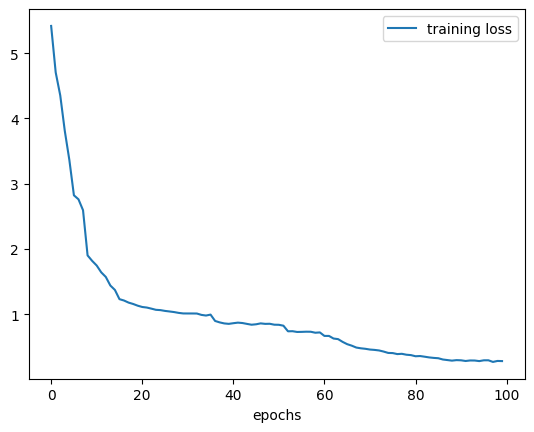

In [23]:
import matplotlib.pyplot as plt
plt.plot(epochs_list, train_loss_list, label = "training loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

### 11. Generating New Abstract using Seed Text

In [ ]:
def generate_abstract(model, seed_text, num_words):
    model.eval()
    with torch.no_grad():
        words = seed_text.split()
        for i in range(num_words):
            inputs = torch.tensor([[word_to_ix[word] for word in words[-seq_length: ]]]).to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)             # Getting the best prediction for the next word
            predicted_word = [k for k, v in word_to_ix.items() if v == predicted.item()][0]
            words.append(predicted_word)
            
    return ' '.join(words)

#### Example 1

In [ ]:
seed_text = "signs of covid"
generated_abstract_1 = generate_abstract(model, seed_text, num_words=40)
print(generated_abstract_1)

signs of covid patients include rapid evaluation. the physical and emotional symptoms that individuals infected with may experience any of the total symptoms. symptoms worsen or if there is difficulty breathing needed to be admitted to the hospital ward and released after care.


#### Example 2

In [ ]:
seed_text = "number of cases"
generated_abstract_2 = generate_abstract(model, seed_text, num_words=40)
print(generated_abstract_2)

number of cases covid is rising the number of confirmed cases has surpassed millions. having limited related efficacy in humans after a single complications result a reduction in covid mortality. nevertheless questions rise around the affordability and underfunding of other parts of healthcare system


#### Example 3

In [ ]:
seed_text = "it also spreads"
generated_abstract_3 = generate_abstract(model, seed_text, num_words=40)
print(generated_abstract_3)

it also spreads easily together through respiratory droplets coughs sneeze. study shows that a increased cftr response to the ongoing spread as well as increased overcrowding and healthcare costs. however direct admission may reduce the risks of spreading the infection at a rapid
